In [1]:
using JupyterFormatter
enable_autoformat()

using JuliaFormatter
format("./src");

In [2]:
using DataFrames
using Graphs
using LinearAlgebra
using Plots
using Random
using StatsBase
using Test: @testset, @test

include("./src/Simulation.jl")
include("./src/SimPlot.jl")
using .Simulation
using .SimPlot: plot_output_df

# Model

In [3]:
@testset "invert" begin
    @test Simulation.invert(C) == D
    @test Simulation.invert(D) == C
end;

Test Summary: | Pass  Total  Time
invert        |    2      2  0.9s


Test Summary: | Pass  Total  Time
ar1_model     |   84     84  0.2s


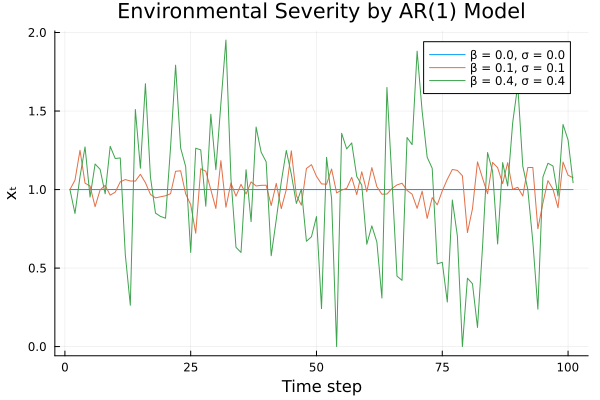

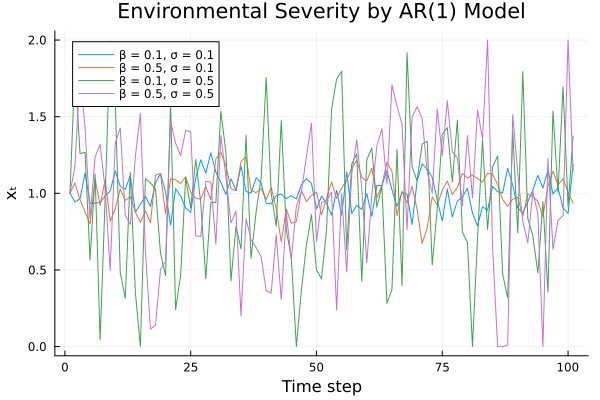

In [4]:
@testset "ar1_model" begin
    T = 100
    for (β, σ) in Iterators.product(0.1:0.1:0.9, 0.1:0.1:0.9)
        @test mean([mean(Simulation.ar1_model(β, σ, T)) for _ = 1:1000]) ≈ 1.0 atol = 0.1
    end
    @test mean([
        std(Simulation.ar1_model(0.2, 0.1, T)) > std(Simulation.ar1_model(0.1, 0.1, T)) for
        _ = 1:1000
    ]) > 0.5
    @test std(Simulation.ar1_model(0.1, 0.2, T)) > std(Simulation.ar1_model(0.1, 0.1, T))
    @test std(Simulation.ar1_model(0.2, 0.2, T)) > std(Simulation.ar1_model(0.1, 0.1, T))
end

function plot_process(params::Vector)::Plots.Plot
    T = 100
    p = plot(
        xlabel = "Time step",
        ylabel = "xₜ",
        title = "Environmental Severity by AR(1) Model",
    )

    for (β, σ) in params
        plot!(Simulation.ar1_model(β, σ, T), label = "β = $(β), σ = $(σ)")
    end

    return p
end

display(plot_process([(0.0, 0.0), (0.1, 0.1), (0.4, 0.4)]))
display(plot_process([(0.1, 0.1), (0.5, 0.1), (0.1, 0.5), (0.5, 0.5)]))

In [5]:
@testset "Model" begin
    @testset "default" begin
        model = Model(Param())

        # agents
        @test model.strategy_vec == fill(D, 1_000)
        @test model.payoff_vec == fill(0.0, 1_000)

        # graph_weights
        @test model.param.initial_graph_weight == 0.5
        @test model.graph_weights == fill(0.5, (1_000, 1_000)) - Diagonal(fill(0.5, 1_000))

        # misc
        @test model.payoff_table[(C, C)] == (1.0, 1.0)
        @test model.payoff_table[(C, D)] == (-0.1, 1.1)
        @test model.payoff_table[(D, C)] == (1.1, -0.1)
        @test model.payoff_table[(D, D)] == (0.0, 0.0)
        @test model.param.interaction_freqency == 1.0
        @test model.param.relationship_volatility == 0.1
        @test model.param.birth_rate == 0.1
        @test isa(model.env_severity_vec, Vector{Float64})
        @test length(model.env_severity_vec) == 11
        @test mean(model.env_severity_vec) ≈ 1.0 atol = 0.5
        @test model.param.δ == 0.01
        @test model.param.μ == 0.00
        @test model.param.generations == 100
        @test isa(model.param.rng, MersenneTwister)
    end

    @testset "customized" begin
        param = Param(
            initial_N = 255,
            initial_graph_weight = 0.123,
            T = 3.3,
            S = 2.2,
            interaction_freqency = 0.111,
            relationship_volatility = 0.19,
            birth_rate = 0.56,
            δ = 0.23,
            μ = 0.45,
            generations = 10_000,
        )
        model = Model(param)

        # agents
        @test model.strategy_vec == fill(D, 255)
        @test model.payoff_vec == fill(0.0, 255)

        # graph_weights
        @test model.param.initial_graph_weight == 0.123
        @test model.graph_weights ==
              Float16.(fill(0.123, (255, 255)) - Diagonal(fill(0.123, 255)))

        # misc
        @test model.payoff_table[(C, C)] == (1.0, 1.0)
        @test model.payoff_table[(C, D)] == (2.2, 3.3)
        @test model.payoff_table[(D, C)] == (3.3, 2.2)
        @test model.payoff_table[(D, D)] == (0.0, 0.0)
        @test model.param.interaction_freqency == 0.111
        @test model.param.relationship_volatility == 0.19
        @test model.param.birth_rate == 0.56
        @test isa(model.env_severity_vec, Vector{Float64})
        @test length(model.env_severity_vec) == 1_001
        @test mean(model.env_severity_vec) ≈ 1.0 atol = 0.5
        @test model.param.δ == 0.23
        @test model.param.μ == 0.45
        @test model.param.generations == 10_000
    end
end;

Test Summary: | Pass  Total  Time
Model         |   35     35  0.4s


# interaction!

In [6]:
@testset "interaction!" begin
    @testset "C vs. C" begin
        model = Model(Param(initial_N = 2, relationship_volatility = 0.2))
        model.strategy_vec[1] = C
        model.strategy_vec[2] = C
        interaction!(model)

        @test model.payoff_vec[1] == 2.0
        @test model.payoff_vec[2] == 2.0
        @test model.graph_weights[1, 2] == Float16(0.5 * 1.2 * 1.2)
        @test model.graph_weights == transpose(model.graph_weights)

        # check weight limit
        model = Model(Param(initial_N = 2, relationship_volatility = 0.9))
        model.strategy_vec[1] = C
        model.strategy_vec[2] = C
        interaction!(model)
        @test model.graph_weights[1, 2] == Float16(1.0)
    end

    @testset "C vs. D" begin
        model = Model(Param(initial_N = 2))
        model.strategy_vec[1] = C
        model.strategy_vec[2] = D
        interaction!(model)

        @test model.payoff_vec[1] == -0.2
        @test model.payoff_vec[2] == 2.2
        @test model.graph_weights[1, 2] == Float16(0.5 * 0.9 * 0.9)
        @test model.graph_weights == transpose(model.graph_weights)
    end

    @testset "D vs. C" begin
        model = Model(Param(initial_N = 2))
        model.strategy_vec[1] = D
        model.strategy_vec[2] = C
        interaction!(model)

        @test model.payoff_vec[1] == 2.2
        @test model.payoff_vec[2] == -0.2
        @test model.graph_weights[1, 2] == Float16(0.5 * 0.9 * 0.9)
        @test model.graph_weights == transpose(model.graph_weights)
    end

    @testset "D vs. D" begin
        model = Model(Param(initial_N = 2, relationship_volatility = 0.3))
        model.strategy_vec[1] = D
        model.strategy_vec[2] = D
        interaction!(model)

        @test model.payoff_vec[1] == 0.0
        @test model.payoff_vec[2] == 0.0
        @test model.graph_weights[1, 2] == Float16(Float16(Float16(0.5) * 0.7) * 0.7)
        @test model.graph_weights == transpose(model.graph_weights)
    end

    @testset "Many agents" begin
        model = Model(Param(initial_N = 10, rng = MersenneTwister(1)))
        model.strategy_vec = repeat([C, D], 5)
        interaction!(model)

        # (focal_id, opponent_id, strategy_pair) = (7, 10, (C, D))
        # (focal_id, opponent_id, strategy_pair) = (9, 7, (C, C))
        # (focal_id, opponent_id, strategy_pair) = (3, 8, (C, D))
        # (focal_id, opponent_id, strategy_pair) = (4, 5, (D, C))
        # (focal_id, opponent_id, strategy_pair) = (5, 4, (C, D))
        # (focal_id, opponent_id, strategy_pair) = (10, 2, (D, D))
        # (focal_id, opponent_id, strategy_pair) = (2, 3, (D, C))
        # (focal_id, opponent_id, strategy_pair) = (8, 6, (D, D))
        # (focal_id, opponent_id, strategy_pair) = (6, 9, (D, C))
        # (focal_id, opponent_id, strategy_pair) = (1, 7, (C, C))
        @test model.payoff_vec ≈ [1.0, 1.1, -0.2, 2.2, -0.2, 1.1, 1.9, 1.1, 0.9, 1.1]

        @test diag(model.graph_weights) == fill(0.0, 10)
        @test model.graph_weights == transpose(model.graph_weights)
        @test model.graph_weights[1, 2:10] ≈
              Float16[0.5, 0.5, 0.5, 0.5, 0.5, 0.55, 0.5, 0.5, 0.5]
        @test model.graph_weights[2, 3:10] ==
              Float16[0.45, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.45]
        @test model.graph_weights[3, 4:10] == Float16[0.5, 0.5, 0.5, 0.5, 0.45, 0.5, 0.5]
        @test model.graph_weights[4, 5:10] == Float16[0.405, 0.5, 0.5, 0.5, 0.5, 0.5]
        @test model.graph_weights[5, 6:10] == Float16[0.5, 0.5, 0.5, 0.5, 0.5]
        @test model.graph_weights[6, 7:10] == Float16[0.5, 0.45, 0.45, 0.5]
        @test model.graph_weights[7, 8:10] == Float16[0.5, 0.55, 0.45]
        @test model.graph_weights[8, 9:10] == Float16[0.5, 0.5]
        @test model.graph_weights[9, 10:10] == Float16[0.5]
    end

    @testset "Many agents (interaction_freqency = 0.149)" begin
        model = Model(
            Param(initial_N = 10, interaction_freqency = 0.149, rng = MersenneTwister(1)),
        )
        model.strategy_vec = repeat([C, D], 5)
        interaction!(model)

        @test model.payoff_vec ≈ [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0, 1.1]

        expected_weights = fill(0.5, (10, 10))
        expected_weights -= Diagonal(expected_weights)
        expected_weights[7, 10] = expected_weights[10, 7] = 0.45
        @test model.graph_weights == Float16.(expected_weights)
    end
end;

Test Summary: | Pass  Total  Time
interaction!  |   31     31  0.6s


# death_and_birth!

Test Summary:   | Pass  Total  Time
classic_fitness |  207    207  0.0s
Test Summary:   | Pass  Total  Time
sigmoid_fitness |    5      5  0.0s


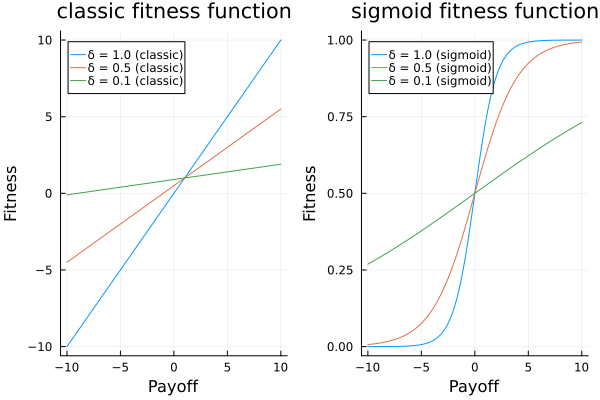

Test Summary: |Time
Visualization | None  0.4s


In [7]:
# 1.0 - δ + δ * payoff
@testset "classic_fitness" begin
    δ = 1.0
    for π = -10.0:0.1:10.0
        @test Simulation.classic_fitness(π, δ) == π
    end
    δ = 0.1
    π_vec = [-10.0, -1.0, 0.0, 1.0, 2.0, 10.0]
    f_vec = [-0.1, 0.8, 0.9, 1.0, 1.1, 1.9]
    for (π, fitness) in zip(π_vec, f_vec)
        @test Simulation.classic_fitness(π, δ) ≈ fitness
    end
end

# 1.0 / (1.0 + exp(-δ * payoff))
@testset "sigmoid_fitness" begin
    δ = 0.5
    @test Simulation.sigmoid_fitness(1_000.0, δ) ≈ 1.0
    @test Simulation.sigmoid_fitness(1.0, δ) ≈ 0.622459331
    @test Simulation.sigmoid_fitness(0.0, δ) == 0.5
    @test Simulation.sigmoid_fitness(-1.0, δ) ≈ 0.37754067
    @test Simulation.sigmoid_fitness(-2_000.0, δ) ≈ 0.0
end

@testset "Visualization" begin
    π_vec = -10.0:0.1:10.0

    p_classic = plot(title = "classic fitness function", xl = "Payoff", yl = "Fitness")

    δ = 1.0
    f_vec = [Simulation.classic_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (classic)")

    δ = 0.5
    f_vec = [Simulation.classic_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (classic)")

    δ = 0.1
    f_vec = [Simulation.classic_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (classic)")

    p_sigmoid = plot(title = "sigmoid fitness function", xl = "Payoff", yl = "Fitness")

    δ = 1.0
    f_vec = [Simulation.sigmoid_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (sigmoid)")

    δ = 0.5
    f_vec = [Simulation.sigmoid_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (sigmoid)")

    δ = 0.1
    f_vec = [Simulation.sigmoid_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (sigmoid)")

    display(plot(p_classic, p_sigmoid))
end;

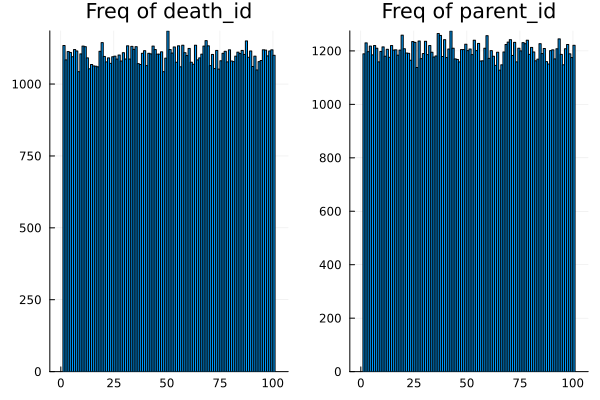

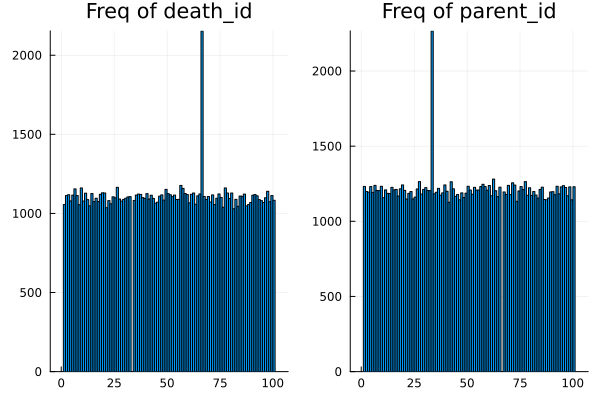

Test Summary:                | Pass  Total  Time
pick_deaths and pick_parents |   14     14  0.9s


In [8]:
@testset "pick_deaths and pick_parents" begin
    @testset "pick_deaths" begin
        model = Model(Param(initial_N = 10))
        Simulation.pick_deaths(model, 0)
    end

    @testset "uniform distribution" begin
        model = Model(Param(initial_N = 100))

        # pick_deaths
        death_id_vec_vec = [Simulation.pick_deaths(model, 11) for _ = 1:10_000]
        death_id_vec = vcat(death_id_vec_vec...)
        @test length(death_id_vec) == 11 * 10_000

        death_id_freq = fit(Histogram, death_id_vec, 1:101).weights
        @test mean(death_id_freq) == 1100
        @test std(death_id_freq) < 150

        p_death =
            histogram(death_id_vec, bins = 100, title = "Freq of death_id", label = false)

        # pick_parents
        parent_id_vec_vec = [Simulation.pick_parents(model, 12) for _ = 1:10_000]
        parent_id_vec = vcat(parent_id_vec_vec...)
        @test length(parent_id_vec) == 12 * 10_000

        parent_id_freq = fit(Histogram, parent_id_vec, 1:101).weights
        @test mean(parent_id_freq) == 1200
        @test std(parent_id_freq) < 150

        p_parent =
            histogram(parent_id_vec, bins = 100, title = "Freq of parent_id", label = false)

        display(plot(p_death, p_parent))
    end

    @testset "polarized situation" begin
        model = Model(Param(initial_N = 100, δ = 1.0))
        model.payoff_vec[33] = 100
        model.payoff_vec[66] = -100

        # pick_deaths
        death_id_vec_vec = [Simulation.pick_deaths(model, 11) for _ = 1:10_000]
        death_id_vec = vcat(death_id_vec_vec...)
        @test length(death_id_vec) == 11 * 10_000

        death_id_freq = fit(Histogram, death_id_vec, 1:101).weights
        @test mean(death_id_freq) == 1100
        @test death_id_freq[33] < 100
        @test death_id_freq[66] > 1800

        p_death =
            histogram(death_id_vec, bins = 100, title = "Freq of death_id", label = false)

        # pick_parents
        parent_id_vec_vec = [Simulation.pick_parents(model, 12) for _ = 1:10_000]
        parent_id_vec = vcat(parent_id_vec_vec...)
        @test length(parent_id_vec) == 12 * 10_000

        parent_id_freq = fit(Histogram, parent_id_vec, 1:101).weights
        @test mean(parent_id_freq) == 1200
        @test parent_id_freq[33] > 1800
        @test parent_id_freq[66] < 100

        p_parent =
            histogram(parent_id_vec, bins = 100, title = "Freq of parent_id", label = false)

        display(plot(p_death, p_parent))
    end
end;

In [9]:
@testset "normalize_graph_weights!" begin
    # before
    model = Model(Param(initial_N = 10))
    @test model.graph_weights == fill(0.5, (10, 10)) - Diagonal(fill(0.5, (10, 10)))
    @test sum(model.graph_weights) == 10 * 9 * 0.5 == 45
    model.graph_weights[1, 2:end] = fill(1.0, 9)

    # execute
    Simulation.normalize_graph_weights!(model)

    # after
    @test diag(model.graph_weights) == fill(0.0, 10)
    @test model.graph_weights[1, 2:end] == Float16.(fill(0.909, 9))
    @test model.graph_weights[2, Not(2)] == Float16.(fill(0.4546, 9))
    @test model.graph_weights[end, Not(end)] == Float16.(fill(0.4546, 9))
    @test sum(model.graph_weights) == Float16(45.03)
end;

Test Summary:            | Pass  Total  Time
normalize_graph_weights! |    7      7  0.1s


In [10]:
@testset "get_death_rate" begin
    model = Model(Param())
    expected_death_rate = model.env_severity_vec .* model.param.birth_rate

    for generation = 1:model.param.generations
        actual_death_rate = Simulation.get_death_rate(model, generation)

        if generation % 10 == 1
            @test actual_death_rate == expected_death_rate[ceil(Int, generation / 10)]
        else
            @test actual_death_rate == Simulation.get_death_rate(model, generation - 1)
        end
    end
end;

Test Summary:  | Pass  Total  Time
get_death_rate |  100    100  0.0s


In [11]:
function make_symmetric_matrix(N::Int)::Matrix{Float16}
    symmetric_matrix = repeat(collect(0.0:1/(N-1):1.0), 1, N)
    symmetric_matrix -= Diagonal(symmetric_matrix)
    symmetric_matrix = (symmetric_matrix + symmetric_matrix') / 2
    return Float16.(symmetric_matrix)
end;

In [12]:
@testset "death_and_birth!" begin
    model = Model(Param())
    byte = @allocated death_and_birth!(model, 1)
    println("$(byte / 1024 / 1024) MB")

    @testset "μ = 0.0" begin
        model = Model(Param(initial_N = 100, birth_rate = 0.03, rng = MersenneTwister(1)))

        # before
        model.strategy_vec[[36 + 2, 39 + 2, 82 + 2]] .= C
        model.graph_weights = make_symmetric_matrix(100)

        # execution
        model.env_severity_vec[1] = 0.7
        death_id_vec, parent_id_vec = death_and_birth!(model, 1)
        @test death_id_vec == [9, 10]
        @test parent_id_vec == [36, 39, 82]

        # after
        @test model.N == length(model.strategy_vec) == length(model.payoff_vec) == 101
        @test size(model.graph_weights) == (101, 101)
        @test model.strategy_vec[99:101] == [C, C, C]
        @test model.graph_weights == transpose(model.graph_weights)  # check symmetry
        @test diag(model.graph_weights) == fill(0.0, 101)  # diagonal is 0.0

        model.graph_weights ./= Float16(0.981)  # for normalization
        _index = setdiff(1:101, [36, 99])
        @test model.graph_weights[36, 99] == model.graph_weights[99, 36] == 1.0
        @test model.graph_weights[36, _index] == model.graph_weights[99, _index]

        _index = setdiff(1:101, [39, 100])
        @test model.graph_weights[39, 100] == model.graph_weights[100, 39] == 1.0
        @test model.graph_weights[39, _index] == model.graph_weights[100, _index]

        _index = setdiff(1:101, [82, 101])
        @test model.graph_weights[82, 101] == model.graph_weights[101, 82] == 1.0
        @test model.graph_weights[82, _index] == model.graph_weights[101, _index]

        # before
        model.strategy_vec[[58 + 4, 61 + 4, 94 + 5]] .= D
        model.graph_weights = make_symmetric_matrix(101)

        # execution
        model.env_severity_vec[1] = 1.6
        death_id_vec, parent_id_vec = death_and_birth!(model, 1)
        @test death_id_vec == [1, 66, 72, 79, 95]
        @test parent_id_vec == [33, 60, 73]

        # after
        @test model.N == length(model.strategy_vec) == length(model.payoff_vec) == 99
        @test size(model.graph_weights) == (99, 99)
        @test model.strategy_vec[[97, 98, 99]] == [D, D, D]
        @test model.graph_weights == transpose(model.graph_weights)  # is symmetry
        @test diag(model.graph_weights) == fill(0.0, 99)  # diagonal is 0.0

        model.graph_weights ./= Float16(1.008)  # for normalization
        _index = setdiff(1:98, [33, 97])
        @test model.graph_weights[33, 97] == model.graph_weights[97, 33] == 1.0
        @test model.graph_weights[33, _index] == model.graph_weights[97, _index]

        _index = setdiff(1:98, [60, 98])
        @test model.graph_weights[60, 98] == model.graph_weights[98, 60] == 1.0
        @test model.graph_weights[60, _index] == model.graph_weights[98, _index]

        _index = setdiff(1:98, [73, 99])
        @test model.graph_weights[73, 99] == model.graph_weights[99, 73] == 1.0
        @test model.graph_weights[73, _index] == model.graph_weights[99, _index]
    end

    @testset "μ = 1.0" begin
        model = Model(
            Param(initial_N = 100, birth_rate = 0.03, μ = 1.0, rng = MersenneTwister(1)),
        )

        # before
        model.strategy_vec[[36 + 2, 39 + 2, 82 + 2]] = [C, D, C]
        model.env_severity_vec[1] = 0.6
        model.graph_weights = make_symmetric_matrix(100)

        # execution
        death_id_vec, parent_id_vec = death_and_birth!(model, 1)
        @test death_id_vec == [9, 10]
        @test parent_id_vec == [36, 39, 82]

        # after
        @test model.N == length(model.strategy_vec) == length(model.payoff_vec) == 101
        @test size(model.graph_weights) == (101, 101)
        @test model.strategy_vec[99:101] == [D, C, D]
        @test model.graph_weights == transpose(model.graph_weights)  # check symmetry
        @test diag(model.graph_weights) == fill(0.0, 101)  # diagonal is 0.0

        model.graph_weights ./= Float16(0.981)  # for normalization
        _index = [x for x in 1:100 if !(x in [36, 99])]
        @test model.graph_weights[36, 99] == model.graph_weights[99, 36] == 1.0
        @test model.graph_weights[36, _index] == model.graph_weights[99, _index]

        _index = [x for x in 1:101 if !(x in [39, 100])]
        @test model.graph_weights[39, 100] == model.graph_weights[100, 39] == 1.0
        @test model.graph_weights[39, _index] == model.graph_weights[100, _index]

        _index = [x for x in 1:101 if !(x in [82, 101])]
        @test model.graph_weights[82, 101] == model.graph_weights[101, 82] == 1.0
        @test model.graph_weights[82, _index] == model.graph_weights[101, _index]
    end
end;

29.038395881652832 MB
Test Summary:    | Pass  Total  Time
death_and_birth! |   39     39  0.5s


# log!

In [13]:
@testset "make_output_df" begin
    df = Simulation.make_output_df(Param(generations = 10_000))
    @test size(df) == (10_000, 26)

    byte = @allocated Simulation.make_output_df(Param(generations = 10_000))
    println("$(byte / 1024 / 1024) MB")
end;

1.1793899536132812 MB
Test Summary:  | Pass  Total  Time
make_output_df |    1      1  0.3s


In [14]:
@testset "log!" begin
    param = Param(initial_N = 10, initial_graph_weight = 1.0, generations = 11)
    output = Simulation.make_output_df(param)
    model = Model(param)

    # default
    byte = @allocated log!(output, 1, model, 1)
    println("$(byte / 1024) KB")

    @test Vector(output[1, 1:11]) ==
          Float64[10, 1.1, -0.1, 1.0, 1.0, 0.1, 0.1, 0.01, 0.0, 0.1, 0.1]
    @test Vector(output[1, 12:22]) ==
          Float16[1, 10, 0.0, 0.0, 0.1, 1.0, 0.0, 9.0, 1.0, 1.0, 1.0]
    @test Vector(output[1, 22:end]) == Float16[1.0, 1.0, 1.0, 1.0, 0.0]

    # cooperation rate and average payoff
    model.strategy_vec = repeat([C, D, D, D, D], 2)
    model.payoff_vec = 0.1:0.1:1.0
    log!(output, 2, model)
    @test Vector(output[2, 12:16]) == Float16[2, 10, 0.2, 0.55, 0.1]

    # average and std of weights
    model = Model(Param(initial_N = 3))
    model.graph_weights = [0.0 1.0 2.0; 1.0 0.0 6.0; 2.0 6.0 0.0]
    log!(output, 3, model, 1)
    @test Vector(output[3, 17:18]) ==
          [mean(Float16[1.0, 2.0, 6.0]), std(Float16[1.0, 2.0, 6.0])]

    # <k>, L, C
    ## regular graph
    model = Model(Param(initial_N = 1_000))
    g = random_regular_graph(1_000, 8)
    model.graph_weights = Matrix(adjacency_matrix(g))
    log!(output, 4, model, 1)
    @test Vector(output[4, 19:21]) ≈ [8.0, 3.6, 0.01] atol = 0.1

    ## scale free network (BA model)
    g = barabasi_albert(1_000, 2, seed = 1)
    model.graph_weights = Matrix(adjacency_matrix(g))
    log!(output, 5, model, 1)
    @test Vector(output[5, 19:21]) ≈ Float16[3.992, 4.038, 0.021] atol = 0.001

    # divided graph
    model = Model(Param(initial_N = 10))
    g = SimpleGraph(10)
    add_edge!(g, (1, 2))
    add_edge!(g, (2, 3))
    add_edge!(g, (3, 4))
    add_edge!(g, (5, 6))
    add_edge!(g, (6, 7))
    add_edge!(g, (8, 9))
    model.graph_weights = Matrix(adjacency_matrix(g))

    byte = @allocated log!(output, 6, model, 1)
    println("$(byte / 1024) KB")

    expected_k = mean([1, 2, 2, 1, 1, 2, 1, 1, 1, 0])
    expected_L = mean([1, 2, 3, 1, 2, 1, 1, 2, 1, 1])
    @test Vector(output[6, 19:21]) ≈ [expected_k, expected_L, 0.0] atol = 0.1

    # component (コンポーネント数, コンポーネントサイズの平均, 最大, 最小, 標準偏差)
    @test Vector(output[6, 22:26]) ==
          Float16[4.0, mean([4, 3, 2, 1])/10, 4.0/10, 1.0/10, std([4, 3, 2, 1])/10]
    @test Vector(output[4, 22:26]) == Float16[1.0, 1.0, 1.0, 1.0, 0.0]
    @test Vector(output[5, 22:26]) == Float16[1.0, 1.0, 1.0, 1.0, 0.0]
    @test Vector(output[3, 22:26]) == Float16[1.0, 1.0, 1.0, 1.0, 0.0]
end;

4986.8662109375 KB
20.734375 KB
Test Summary: | Pass  Total  Time
log!          |   12     12  0.7s


# run

In [15]:
param = Param(initial_graph_weight = 0.2, δ = 0.1, β = 0.01, σ = 0.01, generations = 1_000)
byte = @allocated Simulation.run(param)
println("$(byte / 1024) KB")

2.22559642890625e7 KB


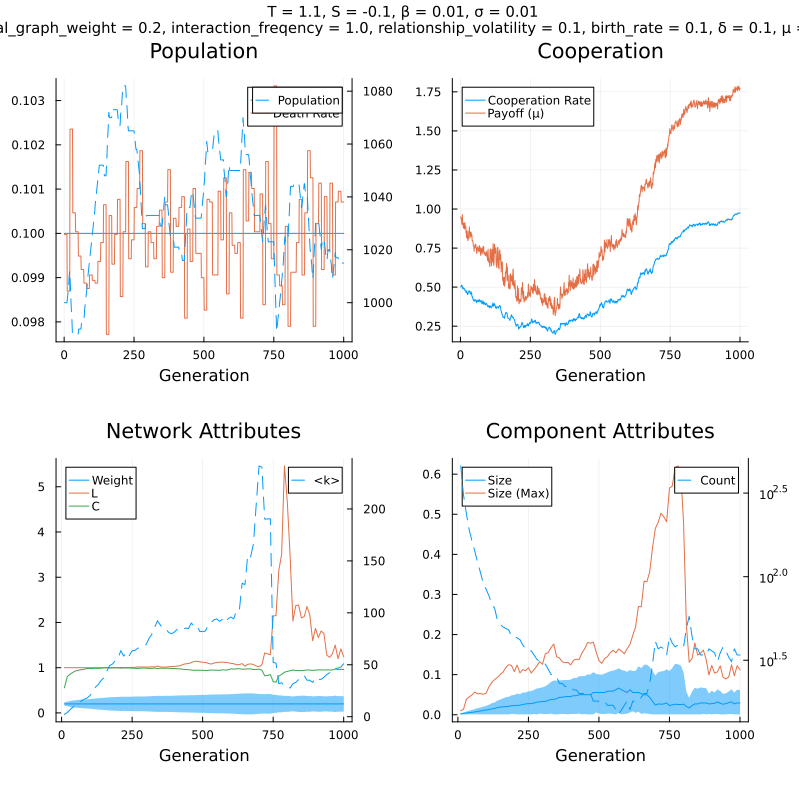

In [16]:
param = Param(initial_graph_weight = 0.2, δ = 0.1, β = 0.01, σ = 0.01, generations = 1_000)
plot_output_df(Simulation.run(param))

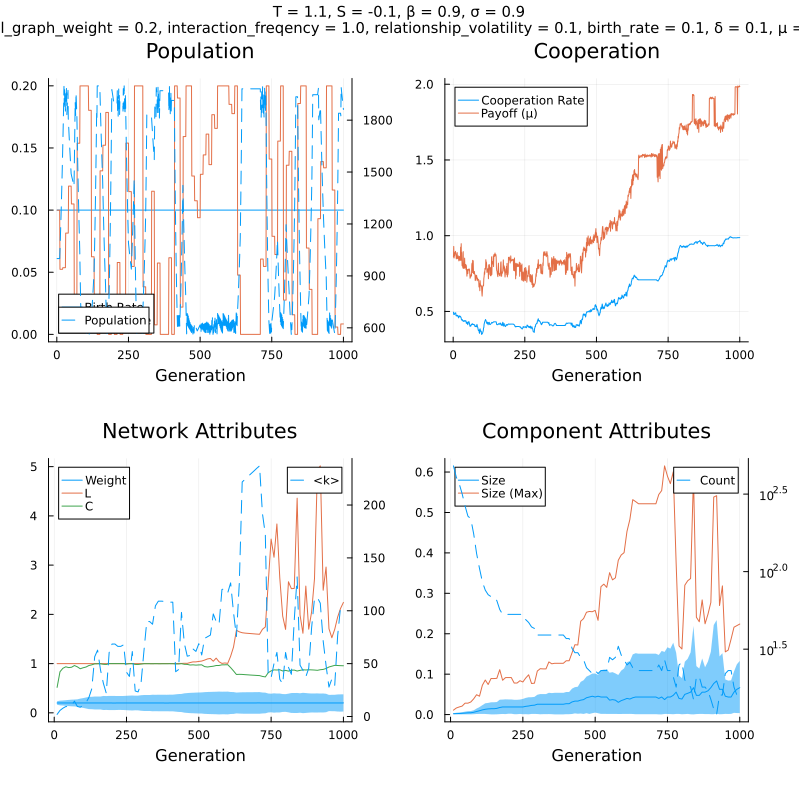

In [17]:
param = Param(initial_graph_weight = 0.2, δ = 0.1, β = 0.9, σ = 0.9, generations = 1_000)
plot_output_df(Simulation.run(param))